## **Create a Retrieval Evaluation Suite**

In [ ]:
import numpy as np
import gdown
import json

def download_and_load_npz(file_id, filename):
    """Télécharge un fichier depuis Google Drive et le charge avec numpy."""
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, filename, quiet=False)
    return np.load(filename)

def download_and_load_json(file_id, filename):
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, filename, quiet=False)
    with open(filename, 'r', encoding='utf-8') as f:
        return json.load(f)

# File IDs
QGTS_ID = "17hVWEcxH8i7-KMkKtvqvPEc_pXSAgrRv"
QUERIES_ID = "1iWsKSjHxUhUTOfkEnM7YpJ-AoFYclemQ"
DOCS_ID = "1k-1lwZG6j0tRN1w-fdfF7XL3TAeP06Dj"

TFIDF_ID = "1XxbfXRAC2wyTKUw13IF28grY56BmSrM4"
BM25_ID = "1HG3rAX-b-LK8kKyDgt_i6avhToRWXzs_"
EMB_ID = "1cfeH66HYqO8T06SUH0XEFUS2gtot1PSk"

# Load the data into variables
documents = download_and_load_json(DOCS_ID, 'docs_processed.json')
queries_train = download_and_load_json(QUERIES_ID, 'queries_train_processed.json')
ground_truth = download_and_load_json(QGTS_ID, 'qgts_train.json')
tfidf_data = download_and_load_npz(TFIDF_ID, 'retrieval_tfidf.npz')
bm25_data = download_and_load_npz(BM25_ID, 'retrieval_bm25.npz')
emb_data = download_and_load_npz(EMB_ID, 'retrieval_embeddings.npz')

# Prepare
doc_contents = [doc['content'] for doc in documents]
query_contents = [q['content'] for q in queries_train]
topk_indices_tfidf = tfidf_data['indices']
topk_scores_tfidf = tfidf_data['scores']
topk_indices_bm25 = bm25_data['indices']
topk_scores_bm25 = bm25_data['scores']
topk_indices_embeddings = emb_data['indices']
topk_scores_embeddings = emb_data['scores']

print("Loaded successfully")
print(f"  TF-IDF: {topk_indices_tfidf.shape}")
print(f"  BM25+: {topk_indices_bm25.shape}")
print(f"  Embeddings: {topk_indices_embeddings.shape}")

Downloading...
From: https://drive.google.com/uc?id=1XxbfXRAC2wyTKUw13IF28grY56BmSrM4
To: /content/retrieval_tfidf.npz
100%|██████████| 317k/317k [00:00<00:00, 78.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HG3rAX-b-LK8kKyDgt_i6avhToRWXzs_
To: /content/retrieval_bm25.npz
100%|██████████| 323k/323k [00:00<00:00, 47.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cfeH66HYqO8T06SUH0XEFUS2gtot1PSk
To: /content/retrieval_embeddings.npz
100%|██████████| 208k/208k [00:00<00:00, 73.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1k-1lwZG6j0tRN1w-fdfF7XL3TAeP06Dj
From (redirected): https://drive.google.com/uc?id=1k-1lwZG6j0tRN1w-fdfF7XL3TAeP06Dj&confirm=t&uuid=9fa41514-76fe-42d3-a482-ecfabcffec71
To: /content/docs_processed.json
100%|██████████| 465M/465M [00:03<00:00, 142MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iWsKSjHxUhUTOfkEnM7YpJ-AoFYclemQ
To: /content/queries_train_processed.json
100%|██████████| 115k/115k [00:00<00:00, 5

Loaded successfully
  TF-IDF: (327, 100)
  BM25+: (327, 100)
  Embeddings: (327, 100)


In [ ]:
def calculate_recall(retrieved_doc_ids, relevant_doc_ids):
    """ Recall = (# correctly retrieved) / (# total relevant)
        Measures how many relevant docs we actually found . """
    if len(relevant_doc_ids) == 0:
        return 0.0
    hits = len(set(retrieved_doc_ids) & set(relevant_doc_ids))
    return hits / len(relevant_doc_ids)


def calculate_precision(retrieved_doc_ids, relevant_doc_ids):
    """ Precision = (# correctly retrieved) / (# total retrieved)
        Measures how many retrieved docs are actually relevant. """
    if len(retrieved_doc_ids) == 0:
        return 0.0
    hits = len(set(retrieved_doc_ids) & set(relevant_doc_ids))
    return hits / len(retrieved_doc_ids)


def calculate_mrr(retrieved_doc_ids, relevant_doc_ids):
    """ MRR = 1 / (rank of first relevant doc)
        Measures how early the first relevant doc appears. """
    for rank, doc_id in enumerate(retrieved_doc_ids, start=1):
        if doc_id in relevant_doc_ids:
            return 1.0 / rank
    return 0.0  # No relevant doc found


print("Evaluation metrics defined :")
print("  - Recall: measures coverage of relevant documents")
print("  - Precision: measures accuracy of retrieved documents")
print("  - MRR: measures ranking quality (position of first hit)")


Evaluation metrics defined
  - Recall: measures coverage of relevant documents
  - Precision: measures accuracy of retrieved documents
  - MRR: measures ranking quality (position of first hit)


In [ ]:
def evaluate_retrieval(topk_indices, method_name, k_values=[10, 50, 100]):
    """ Evaluate retrieval performance across all queries for different k values. """
    results = {}

    for k in k_values:
        recalls = []
        precisions = []
        mrrs = []

        for query_idx, query in enumerate(queries_train):
            query_id = query['id']

            # Skip if no ground truth
            if query_id not in ground_truth:
                continue

            # Get relevant doc IDs from ground truth
            relevant_doc_ids = [item['doc_id'] for item in ground_truth[query_id]['relevant_doc_ids']]

            # Get top-k retrieved doc IDs
            retrieved_indices = topk_indices[query_idx][:k]
            retrieved_doc_ids = [doc_idx_to_id[idx] for idx in retrieved_indices]

            # Calculate metrics
            recalls.append(calculate_recall(retrieved_doc_ids, relevant_doc_ids))
            precisions.append(calculate_precision(retrieved_doc_ids, relevant_doc_ids))
            mrrs.append(calculate_mrr(retrieved_doc_ids, relevant_doc_ids))

        # Store average metrics for this k
        results[k] = {
            'recall': np.mean(recalls),
            'precision': np.mean(precisions),
            'mrr': np.mean(mrrs),
            'num_queries': len(recalls)
        }

    return results


print("Evaluation function defined")


Evaluation function defined


In [ ]:
doc_id_to_idx = {doc['id']: i for i, doc in enumerate(documents)}
doc_idx_to_id = {i: doc['id'] for i, doc in enumerate(documents)}

# Parse ground truth structure (extract just the doc IDs)
ground_truth_parsed = {}
for query_id, gt_data in ground_truth.items():
    doc_ids = [item['doc_id'] for item in gt_data['relevant_doc_ids']]
    ground_truth_parsed[query_id] = doc_ids

In [35]:
print("Evaluating TF-IDF retrieval :")

tfidf_results = evaluate_retrieval(topk_indices_tfidf, "TF-IDF")

for k, metrics in tfidf_results.items():
    print(f"\nWith k={k} :")
    print(f"  Recall :    {metrics['recall']:.4f}")
    print(f"  Precision : {metrics['precision']:.4f}")
    print(f"  MRR :       {metrics['mrr']:.4f}")

Evaluating TF-IDF retrieval :

With k=10 :
  Recall :    0.0791
  Precision : 0.0486
  MRR :       0.1367

With k=50 :
  Recall :    0.1662
  Precision : 0.0212
  MRR :       0.1462

With k=100 :
  Recall :    0.2169
  Precision : 0.0142
  MRR :       0.1471


In [36]:
print("Evaluating BM25+ retrieval :")

bm25_results = evaluate_retrieval(topk_indices_bm25, "BM25+")

for k, metrics in bm25_results.items():
    print(f"\nWith k={k}:")
    print(f"  Recall :    {metrics['recall']:.4f}")
    print(f"  Precision : {metrics['precision']:.4f}")
    print(f"  MRR :       {metrics['mrr']:.4f}")

Evaluating BM25+ retrieval :

With k=10:
  Recall :    0.1178
  Precision : 0.0716
  MRR :       0.1778

With k=50:
  Recall :    0.2010
  Precision : 0.0264
  MRR :       0.1851

With k=100:
  Recall :    0.2434
  Precision : 0.0158
  MRR :       0.1861


In [37]:
print("Evaluating Embedding-based retrieval :")

embeddings_results = evaluate_retrieval(topk_indices_embeddings, "Embeddings")

for k, metrics in embeddings_results.items():
    print(f"\nWith k={k} :")
    print(f"  Recall :    {metrics['recall']:.4f}")
    print(f"  Precision : {metrics['precision']:.4f}")
    print(f"  MRR :       {metrics['mrr']:.4f}")


Evaluating Embedding-based retrieval :

With k=10 :
  Recall :    0.1959
  Precision : 0.1141
  MRR :       0.2745

With k=50 :
  Recall :    0.3533
  Precision : 0.0461
  MRR :       0.2839

With k=100 :
  Recall :    0.4184
  Precision : 0.0284
  MRR :       0.2846


In [47]:
import pandas as pd

def create_comparison_table(tfidf_res, bm25_res, emb_res, k=100):
    """ Create comparison table for a specific k value. """
    data = {
        'Method': ['TF-IDF', 'BM25+', 'Embeddings'],
        f'Recall ': [
            tfidf_res[k]['recall'],
            bm25_res[k]['recall'],
            emb_res[k]['recall']
        ],
        f'Precision ': [
            tfidf_res[k]['precision'],
            bm25_res[k]['precision'],
            emb_res[k]['precision']
        ],
        f'MRR ': [
            tfidf_res[k]['mrr'],
            bm25_res[k]['mrr'],
            emb_res[k]['mrr']
        ]
    }

    df = pd.DataFrame(data)
    return df


print("Comparative Results")

for k in [10, 50, 100]:
    print(f"\nResults with k={k}")
    comparison_df = create_comparison_table(tfidf_results, bm25_results, embeddings_results, k=k)
    print(comparison_df.to_string(index=False))

Comparative Results

Results with k=10
    Method  Recall   Precision      MRR 
    TF-IDF 0.079109    0.048624 0.136667
     BM25+ 0.117842    0.071560 0.177779
Embeddings 0.195911    0.114067 0.274530

Results with k=50
    Method  Recall   Precision      MRR 
    TF-IDF 0.166217    0.021162 0.146201
     BM25+ 0.200982    0.026361 0.185100
Embeddings 0.353299    0.046116 0.283872

Results with k=100
    Method  Recall   Precision      MRR 
    TF-IDF 0.216884    0.014190 0.147080
     BM25+ 0.243361    0.015810 0.186076
Embeddings 0.418370    0.028379 0.284639


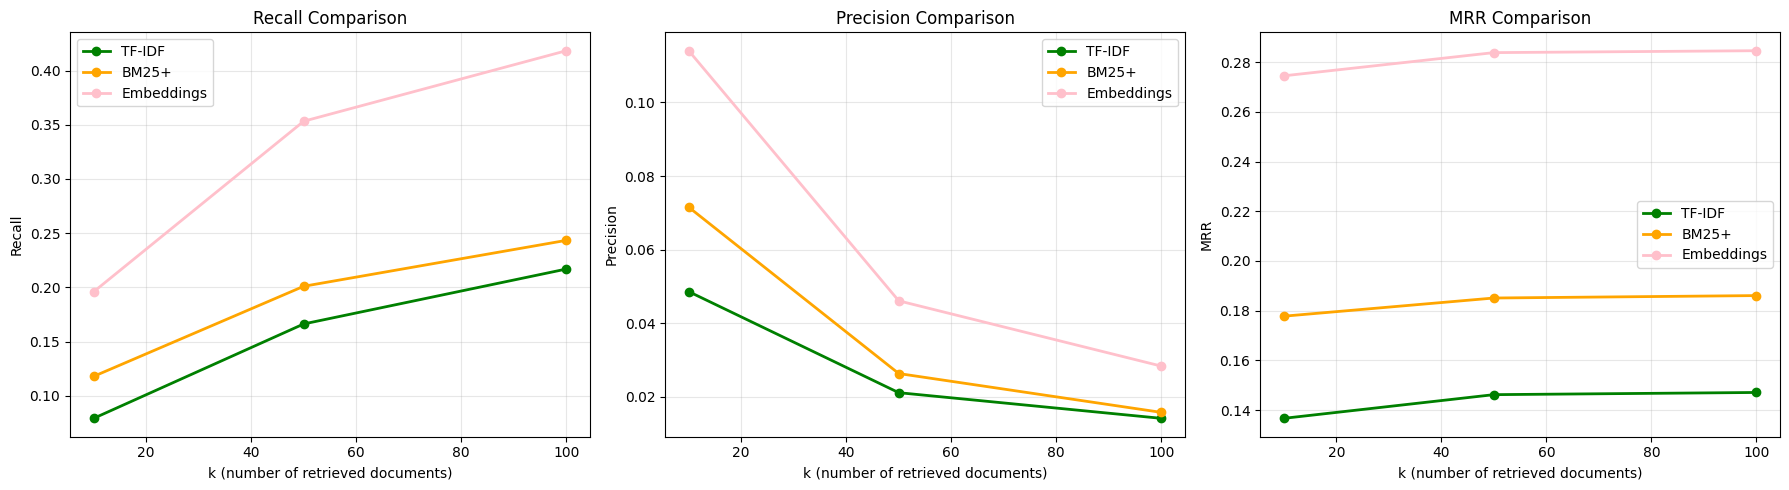

In [48]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

k_vals = [10, 50, 100]
methods = ['TF-IDF', 'BM25+', 'Embeddings']
colors = ['green', 'orange', 'pink']

# Recall comparison
for method, color, results in zip(methods, colors, [tfidf_results, bm25_results, embeddings_results]):
    recalls = [results[k]['recall'] for k in k_vals]
    axes[0].plot(k_vals, recalls, marker='o', label=method, color=color, linewidth=2)

axes[0].set_xlabel('k (number of retrieved documents)')
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision comparison
for method, color, results in zip(methods, colors, [tfidf_results, bm25_results, embeddings_results]):
    precisions = [results[k]['precision'] for k in k_vals]
    axes[1].plot(k_vals, precisions, marker='o', label=method, color=color, linewidth=2)

axes[1].set_xlabel('k (number of retrieved documents)')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# MRR comparison
for method, color, results in zip(methods, colors, [tfidf_results, bm25_results, embeddings_results]):
    mrrs = [results[k]['mrr'] for k in k_vals]
    axes[2].plot(k_vals, mrrs, marker='o', label=method, color=color, linewidth=2)

axes[2].set_xlabel('k (number of retrieved documents)')
axes[2].set_ylabel('MRR')
axes[2].set_title('MRR Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [50]:
# Analyze which queries are hardest
def analyze_difficult_queries(topk_indices, ground_truth_dict, method_name, k=100):
    """ Find queries where retrieval performs poorly. """
    query_performance = []

    for query_idx, query in enumerate(queries_train):
        query_id = query['id']

        if query_id not in ground_truth_dict:
            continue

        relevant_doc_ids = [item['doc_id'] for item in ground_truth_dict[query_id]['relevant_doc_ids']]
        retrieved_indices = topk_indices[query_idx][:k]
        retrieved_doc_ids = [doc_idx_to_id[idx] for idx in retrieved_indices]

        recall = calculate_recall(retrieved_doc_ids, relevant_doc_ids)

        query_performance.append({
            'query_id': query_id,
            'query_text': query['content'][:80] + '...',
            'category': query.get('category', 'N/A'),
            'recall': recall,
            'num_relevant': len(relevant_doc_ids)
        })

    # Sort by recall (worst first)
    query_performance.sort(key=lambda x: x['recall'])

    return query_performance

print("Difficult Queries Analysis (Embeddings, k=100)")

difficult_queries = analyze_difficult_queries(topk_indices_embeddings, ground_truth, "Embeddings", k=100)

print("\nTop 10 hardest queries (lowest recall):")
for i, query_info in enumerate(difficult_queries[:10], 1):
    print(f"{i}. Recall: {query_info['recall']:.3f} | Relevant docs: {query_info['num_relevant']}")
    print(f"   Category: {query_info['category']}")
    print(f"   Query: {query_info['query_text']}")


Difficult Queries Analysis (Embeddings, k=100)

Top 10 hardest queries (lowest recall):
1. Recall: 0.000 | Relevant docs: 15
   Category: tex
   Query: Left and right braces on different lines of align tikz-pgf horizontal-alignment ...
2. Recall: 0.000 | Relevant docs: 4
   Category: tex
   Query: Highlighting labels of undefined citations? tikz-pgf horizontal-alignment tikz-t...
3. Recall: 0.000 | Relevant docs: 9
   Category: tex
   Query: \href without decoration (no underline) tikz-pgf horizontal-alignment tikz-trees...
4. Recall: 0.000 | Relevant docs: 4
   Category: tex
   Query: Absolute Value Symbols tikz-pgf horizontal-alignment tikz-trees...
5. Recall: 0.000 | Relevant docs: 5
   Category: programmers
   Query: Write then optimise or write optimised web-development python sql concurrency sq...
6. Recall: 0.000 | Relevant docs: 4
   Category: android
   Query: Disable screen lock on samsung galaxy pocket gt s5300 linux development...
7. Recall: 0.000 | Relevant docs: 4
   Cate

#### Retrieval Performance Analysis

Looking at the comparative results across all three methods (TF-IDF, BM25+, and Embeddings), we observe several important patterns:

**1. Embeddings dominate across all metrics**

Looking at the comparative results, Embeddings emerge as the undeniable winner. At k=100, Embeddings achieve a Recall of ~41.8% and an MRR of ~0.284, vastly outperforming lexical methods. The gap widens as k increases, showing that embeddings maintain their retrieval quality deeper in the rankings. This proves that semantic understanding  is crucial for bridging the gap between how users phrase questions and how documentation is written.

**2. BM25+ Shows Clear Advantages Over TF-IDF**

While both are lexical models, BM25+ demonstrates a measurable improvement over standard TF-IDF. In our tests, BM25+ reached an MRR of ~0.186 compared to TF-IDF's ~0.147 (a relative improvement of >25%). This confirms that BM25+'s theoretical advantages—specifically term frequency saturation and document length normalization—effectively handle the high variance in document lengths within our dataset. However, both lexical methods eventually hit a hard ceiling (max ~24% recall) due to the vocabulary mismatch problem.

**3. Impact of k value**

Across all models, we observe the standard Information Retrieval trade-offs:
   - Recall naturally increases with k as the system is allowed to return more candidates
   - Precision drops drastically as k increases. This is expected since the number of actual relevant documents per query in our ground truth is very small (often just 3 to 6).
   - MRR remains highly stable across k=10, 50, 100. This indicates that if a model is capable of finding a relevant document, it generally ranks it highly; increasing k mostly adds tail-end noise rather than shifting the top-1 result.

**4. Deep Dive into Difficult Queries**

By analyzing the specific queries where our best model (Embeddings) completely failed (Recall = 0.000), a clear pattern emerges:

Keyword Overload / Structural Noise: Many failing queries (e.g., "How to reference an Annex tikz-pgf horizontal-alignment tikz-trees...") contain a massive dump of disjointed tags rather than natural sentences. While embeddings capture natural language beautifully, they get confused by long strings of raw technical tags which skew the sentence's spatial vector.

Niche Technical Jargon: Queries heavily specific to narrow domains (especially in tex and gaming, such as exact Minecraft/Skyrim mechanics or LaTeX formatting quirks) struggle. General-purpose embedding models (like all-MiniLM-L6-v2) lack the highly specialized vocabulary to map these niche technical terms to their relevant documents.


**Conclusion:**

For this retrieval task, embeddings are the clear winner despite computational costs. The quality improvement justifies the complexity, especially for production systems where encoding happens once
and query-time retrieval remains fast.